# Crop Classification from Sentinel-2 Satellite Imagery with XGBoosted Trees

Agricultural monitoring is least developed for smallholders in low- and middle-income countries — communities most likely to be impacted by hunger, poverty, and climate change. Recent efforts to monitor smallholder productivity are limited in spatial and temporal scope.

In this notebook, we provide an end-to-end machine learning pipeline built on satellite data from Google Earth Engine for high-resolution, wall-to-wall time series mapping of crop area and yield, demonstrated for maize at every 10-meter pixel in Rwanda over 2019-2023. Gradient boosted tree models are built from more than 60,000 field-level labels, 9,000 yield measurements, and satellite-derived inputs. 

Maize is classified with 83% accuracy, precision of 0.70, and recall of 0.44 and total maize cover was predicted within 4% of national statistics. Yields aggregated to districts had an RMSE of 370kg/ha (27%). It helps to create a dataset for smallholder maize classification and yield
estimation product for sub-Saharan Africa while being accessible, low-cost, standardized, and
observed over time; thus, being more likely to enable technology transfer and innovation for
many uses cases and users.

Below is a diagram outlining the methods used here. For the full context, we recommended you review [this pre-print paper](https://github.com/Better-Planet-Laboratory/ai4good/blob/8952fc8659b9f10fcd2dc164fac2236cd1462a1b/Notebooks/wk6/FankhauserEtal_2024_Preprint.pdf) for greater detail on context, data sources and types, and the aims/challenges of this work.

![methods](https://github.com/Better-Planet-Laboratory/ai4good/blob/wk6/Notebooks/wk6/crop_yield_methods.png?raw=true)
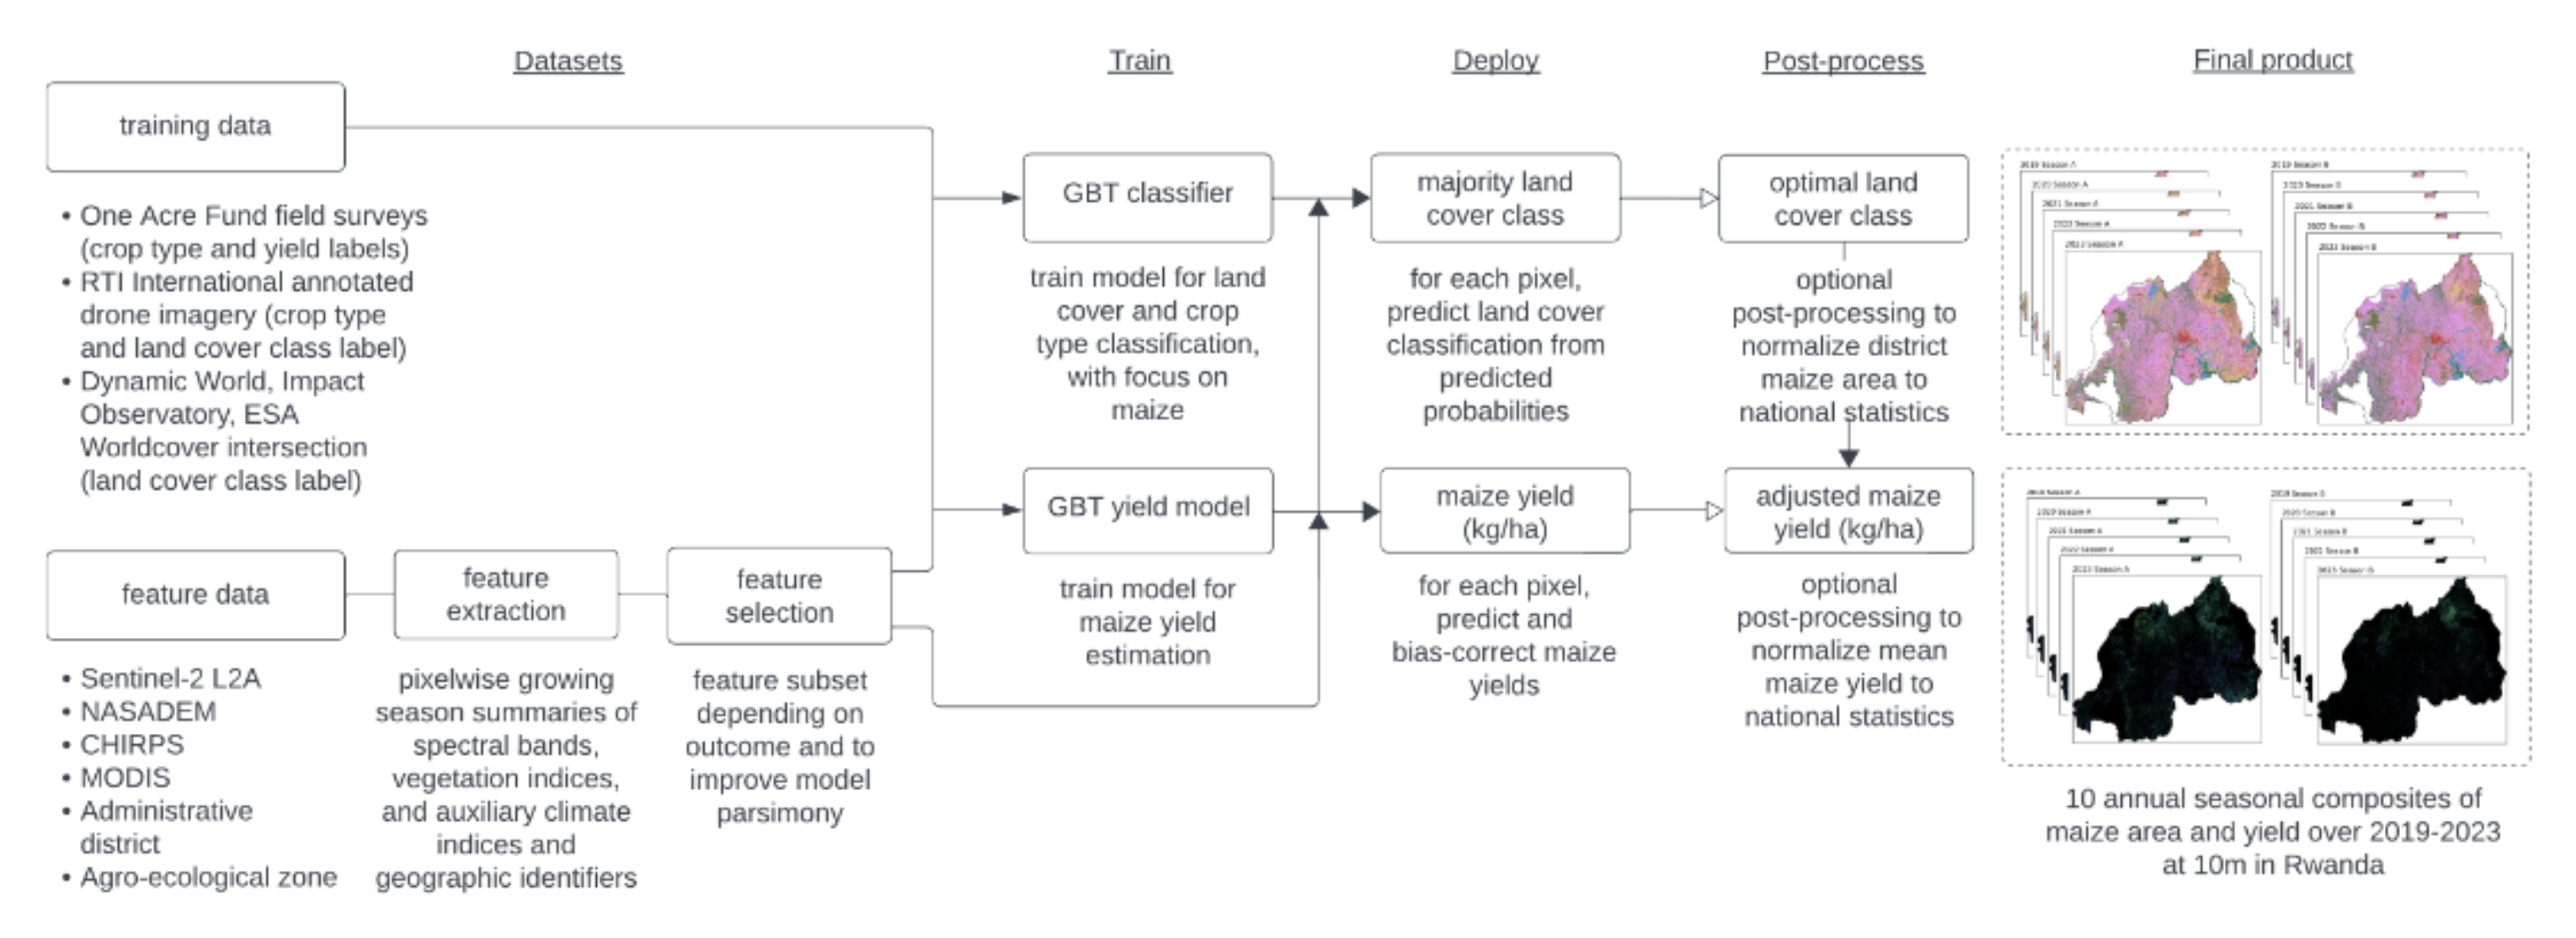

## Outline

1. [Data Use Agreement](#Data-Use-Agreement)
1. [Environment Setup](#Environment-Setup)
1. [Collect and Clean data](#Data)
1. [Feature Selection](#Feature-Selection)
1. [Build Model](#Build-Model)
1. [Tune Model](#Tune-Model)
1. [Evaluate Model](#Evaluate-Model)
1. [Assignment](#Assignment)

## Data Use Agreement
This notebook uses proprietary data with permission from the owners. Please read the following statement and type "I agree, Full Name" in the cell below: 

> I understand that this notebook is using real data from real people with the intent of making the challenge practical and reflective of real-world challenges. I agree to not to share it with anyone else nor to attempt to identify the individuals whom the data is about.

In [30]:
# Read the statement above and then type "I agree" and your full name to the print statement below
print('I agree, Isaiah Lyons-Galante')

I agree, Isaiah Lyons-Galante


## Environment Setup
We'll just use the CPU for this notebook since there are no images to process nor neural networks for a GPU to optimize.

In [1]:
# some general packages we'll use:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os

pd.options.display.float_format = '{:.2f}'.format  # limit decimal places displayed for easier viewing

# additional packages needed for modeling
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score,
    f1_score, precision_recall_fscore_support,
    matthews_corrcoef, confusion_matrix
)

print('imported')

imported


## Data for Land Cover Classification

Optical imagery from the Sentinel-2 satellite and auxiliary data on climate, geography, and geopolitical boundaries were used in supervised learning with crop cut data (primarily) collected in the field.  

Land cover was classified into nine mutually exclusive groups: 1) maize, 2) non-maize annual crops (e.g. beans, potatoes, cassava), 3) non-maize perennial crops (e.g. bananas), 4) forest and tree cover, 5) shrub and scrubland, given the shorthand name of rangeland here, 6) structure and built environment, 7) bare ground, 8) wetland, 9) water bodies. 

The raw spectral output of 12 Sentinel-2 bands as well as several derived indices were summarized by agricultural season with distributional statistics (mean, standard deviation, min, max).

One Acre Fund (OAF) provided the crop cut data for major crops in Rwanda while data for other land cover classes was augmented with RTI International annotated drone imagery and existing global land cover products from Dynamic World (DW), Impact Observatory (IO), and the European Space Agency (ESA).

See the following table for detail on each input feature. The data provided to you includes all of these variables, but for the purposes of this tutorial we will only use a subset.  

![data-fields-description](https://github.com/Better-Planet-Laboratory/ai4good/blob/wk6/Notebooks/wk6/predictor_descriptions.png?raw=true)

In [2]:
# set data configurations
base_path = "/kaggle/input/rwanda-crop-yields-with-sentinel-2-data/"
classifier_data_filename = "training_data_for_classifier.parquet"
yield_data_filename = "training_data_for_yield.csv"

print('configured')

configured


In [3]:
# read in the data from a parquet file
# learn more about parquet: https://www.databricks.com/glossary/what-is-parquet
data_raw = pd.read_parquet(os.path.join(base_path, classifier_data_filename))
print('data imported')

data imported


In [4]:
# count the sample size by land cover class
data_raw['crop_type'].value_counts(dropna=False)

crop_type
nonmaize_annual       19957
maize                  9719
forest                 8645
rangeland              3187
water                  2994
wetland                2887
structure              2345
nonmaize_perennial      363
bare                    345
Name: count, dtype: int64

In [5]:
# count the sample size by data source
data_raw['crop_id'].apply(lambda s: re.sub(r"_[0-9]+", "", s)).value_counts(dropna=False)

crop_id
oaf          28881
dw_io_esa    19757
rti           1804
Name: count, dtype: int64

## Feature Selection

In the paper, we used an empirical feature selection strategy that chose variables with the highest Mutual Information Scores that were not highly correlated with other variables. Read more about it in the methods section. 

Here, we will manually select variables given our expert knowledge and build a model from mean seasonal Sentinel-2 spectral information, one derived index, and topographic information from a Digital Elevation Model (DEM). Learn more about elevation, slope, and aspect [here](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/aspect-slope-function.htm).

**Question:** Based on the data description table above, what other features do you think might be predictive of land cover type? What's the advantage of doing empirical feature selection versus using expert knowledge?

**Your Answer:**

In [6]:
id_cols = ['crop_id', 'crop_type', 'label', 'intercrop', 'season', 'sos_actual']
s2_predictors = data_raw.columns[data_raw.columns.str.contains("B[0-9]*_mean$")].tolist()
topo_predictors = ['elevation', 'slope', 'aspect']
predictors = s2_predictors + topo_predictors
print("Predictors:", predictors)

Predictors: ['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B9_mean', 'B11_mean', 'B12_mean', 'elevation', 'slope', 'aspect']


In [7]:
# subset the data to just the predictors of interest
data = data_raw.filter(id_cols + predictors)
data

,crop_id,crop_type,label,intercrop,season,sos_actual,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,B11_mean,B12_mean,elevation,slope,aspect
0,oaf_53465,maize,mze,0.00,2023_Season_A,20220901,0.04,0.04,0.07,0.07,0.12,0.27,0.30,0.30,0.32,0.18,0.11,1770.83,8.63,204.91
1,oaf_47129,nonmaize_annual,pot,1.00,2023_Season_A,20220901,0.05,0.05,0.07,0.07,0.11,0.21,0.24,0.23,0.27,0.18,0.13,2259.86,4.84,99.71
2,oaf_52319,nonmaize_annual,bub,1.00,2023_Season_A,20220901,0.04,0.05,0.07,0.07,0.13,0.26,0.30,0.31,0.29,0.25,0.17,1622.87,8.22,299.02
3,oaf_58952,maize,mze,1.00,2023_Season_A,20220901,0.04,0.05,0.07,0.08,0.12,0.20,0.22,0.22,0.25,0.21,0.15,1742.83,11.63,118.19
4,oaf_56441,nonmaize_annual,clb,1.00,2023_Season_A,20220901,0.05,0.06,0.10,0.11,0.17,0.25,0.27,0.28,0.28,0.25,0.18,2212.32,13.50,260.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50437,oaf_622,nonmaize_annual,pot,0.00,2022_Season_A,20210901,0.04,0.05,0.09,0.08,0.14,0.28,0.32,0.30,0.35,0.24,0.15,1911.79,5.74,180.00
50438,oaf_11209,nonmaize_annual,bub,1.00,2022_Season_A,20210901,0.05,0.05,0.07,0.08,0.12,0.22,0.25,0.25,0.26,0.21,0.15,1420.75,3.20,308.59
50439,oaf_9394,nonmaize_annual,pot,0.00,2022_Season_A,20210901,0.06,0.07,0.10,0.09,0.16,0.34,0.40,0.40,0.40,0.27,0.16,2120.43,15.62,338.31
50440,oaf_5217,nonmaize_annual,bub,0.00,2022_Season_A,20210901,0.05,0.06,0.09,0.10,0.13,0.21,0.23,0.22,0.24,0.21,0.15,1424.67,8.88,312.61


Let's compute the Normalized Difference Vegetation Index (NDVI), one of the most commonly used indices to measure vegetative health from satellite data. 

NDVI is a ratio between the Red and Near-Infrared bands and measures the amount of red light and near-infrared light absorbed on the ground. Typically, a plant is healthier if it absorbs more red light relative to infrared light (NDVI close to 1) while NDVI values close to 0 or negative values can indicate unhealthy vegetation or areas of non-vegetation such as bare ground, structures, or fallowed fields. Learn more about [NDVI here](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/).

(Note: The mean seasonal NDVI we calculate will be different than that given in the raw data ('ndvi_mean') because the latter represents a mean of daily NDVIs whereas here we are computing mean NDVI from variables that are already averaged over the season.)

In [8]:
def compute_ndvi(b8, b4): 
    return (b8-b4) / (b8+b4)

data['ndvi_mean'] = data.apply(lambda df: compute_ndvi(df['B8_mean'], df['B4_mean']), axis=1)

# add to predictors list
predictors = predictors + ['ndvi_mean']

print('ndvi added to predictors')

ndvi added to predictors


## Build Model

We will use a gradient boosted decision tree to predict land cover type. Particularly, the model we will use is called [XGBoost (eXtreme Gradient Boosting)](https://www.geeksforgeeks.org/xgboost/).

The advantages of this model for our prediction task are:
* Supervised learning that can solve both regression and classification, including multinomial, problems
* Non-parametric so does not require a lot of assumptions
* More easily solves non-linear problems with decision boundaries
* Hierarchical and detects interactions between features
* Accepts heterogeneous data, robust to outliers, and requires less pre-processing (e.g. does not require feature scaling or normalization)

**Question:** What are some of the limitations of XGBoost?

**Your Answer:** 

### Prepare Data for Modeling
The model expects that the target (i.e. outcome) is numeric and that the dataset does not contain missing data so first we must do some additional cleaning. 

In [9]:
# create nominal outcome 
data['land_cover_class'] = pd.Categorical(  # order that matches original paper
    data['crop_type'],
    categories=['maize', 'nonmaize_annual', 'nonmaize_perennial', 'rangeland', 'forest', 'wetland', 'water', 'structure', 'bare'],  
    ordered=True
    )
data['land_cover_class_encoded'] = data['land_cover_class'].cat.codes

# remove missing data in outcome and predictors (if any)
data.dropna(subset = ['land_cover_class_encoded'] + predictors, inplace = True)

data


,crop_id,crop_type,label,intercrop,season,sos_actual,B1_mean,B2_mean,B3_mean,B4_mean,...,B8_mean,B9_mean,B11_mean,B12_mean,elevation,slope,aspect,ndvi_mean,land_cover_class,land_cover_class_encoded
0,oaf_53465,maize,mze,0.00,2023_Season_A,20220901,0.04,0.04,0.07,0.07,...,0.30,0.32,0.18,0.11,1770.83,8.63,204.91,0.61,maize,0
1,oaf_47129,nonmaize_annual,pot,1.00,2023_Season_A,20220901,0.05,0.05,0.07,0.07,...,0.23,0.27,0.18,0.13,2259.86,4.84,99.71,0.53,nonmaize_annual,1
2,oaf_52319,nonmaize_annual,bub,1.00,2023_Season_A,20220901,0.04,0.05,0.07,0.07,...,0.31,0.29,0.25,0.17,1622.87,8.22,299.02,0.62,nonmaize_annual,1
3,oaf_58952,maize,mze,1.00,2023_Season_A,20220901,0.04,0.05,0.07,0.08,...,0.22,0.25,0.21,0.15,1742.83,11.63,118.19,0.46,maize,0
4,oaf_56441,nonmaize_annual,clb,1.00,2023_Season_A,20220901,0.05,0.06,0.10,0.11,...,0.28,0.28,0.25,0.18,2212.32,13.50,260.21,0.44,nonmaize_annual,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50437,oaf_622,nonmaize_annual,pot,0.00,2022_Season_A,20210901,0.04,0.05,0.09,0.08,...,0.30,0.35,0.24,0.15,1911.79,5.74,180.00,0.57,nonmaize_annual,1
50438,oaf_11209,nonmaize_annual,bub,1.00,2022_Season_A,20210901,0.05,0.05,0.07,0.08,...,0.25,0.26,0.21,0.15,1420.75,3.20,308.59,0.52,nonmaize_annual,1
50439,oaf_9394,nonmaize_annual,pot,0.00,2022_Season_A,20210901,0.06,0.07,0.10,0.09,...,0.40,0.40,0.27,0.16,2120.43,15.62,338.31,0.63,nonmaize_annual,1
50440,oaf_5217,nonmaize_annual,bub,0.00,2022_Season_A,20210901,0.05,0.06,0.09,0.10,...,0.22,0.24,0.21,0.15,1424.67,8.88,312.61,0.40,nonmaize_annual,1



Additionally, in order to tune and evaluate our model on independent datasets we need to split our data into training and testing sets. 

In [25]:
# split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    data.filter(predictors), # predictors
    data['land_cover_class_encoded'], # outcome
    test_size=0.2, # 20% of data reserved for testing set
    random_state=123  # seed for reproducibility 
)
print("Size of training dataset: {} observations".format(len(x_train)))
print("Size of test dataset: {} observations".format(len(x_test)))

# set up data for model
# xgb expects data to be a DMatrix object 
dtrain = xgb.DMatrix(x_train, label=y_train)  
dtest = xgb.DMatrix(x_test, label=y_test)

Size of training dataset: 40353 observations
Size of test dataset: 10089 observations


### Configure the Model

Later we will tune our model to select the best hyperparameters, but for now use the following given hyperparameters. A full list of those available in XGBoost can be found [here](https://xgboost.readthedocs.io/en/latest/parameter.html). 

In [26]:
# Choose hyperparameters for XGBoost
param = {
    'objective': 'multi:softmax',  # Specifies that we are solving a multiclass classification problem.
                                   # 'multi:softmax' applies the softmax function to output class probabilities.
                                   # Alternative: 'multi:softprob' outputs raw probabilities instead of class labels.

    'num_class': data['land_cover_class_encoded'].nunique(),  
                                   # Number of unique classes in the target variable.
                                   # Required for multiclass classification.

    'eval_metric': ['mlogloss', 'merror'],  
                                   # Evaluation metrics to assess model performance:
                                   # 'mlogloss': Multinomial negative log-likelihood (cross-entropy loss for multiple classes).
                                   # 'merror': Multiclass classification error rate (fraction of incorrect predictions).

    'subsample': 0.5,              # Fraction of training data used for training each tree (stochastic training).
                                   # Reducing it below 1.0 helps prevent overfitting by introducing randomness.
                                   # Values typically range from 0.5 to 1.0.

    'sampling_method': 'uniform',  # Specifies how samples are selected when 'subsample' is used.
                                   # 'uniform': Randomly selects samples with equal probability.
                                   # 'gradient_based': Prioritizes more informative samples (less common for classification tasks).

    'eta': 0.3,                    # Learning rate (also known as "shrinkage factor").
                                   # Controls the contribution of each tree to the final prediction.
                                   # Lower values (e.g., 0.1) slow down learning, requiring more trees to converge.
                                   # Higher values (e.g., 0.3) speed up learning but risk overfitting.

    'max_depth': 6,                # Maximum depth of each decision tree.
                                   # Higher values allow more complex patterns to be learned but increase overfitting risk.
                                   # Lower values help with generalization but may miss complex patterns.
                                   # Typical values: 3–10.

    'min_child_weight': 1,         # Minimum sum of instance weights required in a child node.
                                   # Higher values make trees more conservative by requiring larger splits.
                                   # Lower values allow smaller child nodes, making trees more complex.
                                   # Default is 1.

    'seed': 529                    # Random seed for reproducibility.
                                   # Ensures that results remain consistent when running the model multiple times.
}

param

{'objective': 'multi:softmax',
 'num_class': 9,
 'eval_metric': ['mlogloss', 'merror'],
 'subsample': 0.5,
 'sampling_method': 'uniform',
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'seed': 529}

### Train the Model

In [29]:
# train model
classifier = xgb.train(
    params=param, dtrain=dtrain, 
    num_boost_round=1000,  # number of boosting iterations, 
    early_stopping_rounds=100,  # helps control overfitting
    evals=[(dtrain, 'train'), (dtest, 'eval')], verbose_eval=100
)

[0]	train-mlogloss:1.60604	train-merror:0.32875	eval-mlogloss:1.61553	eval-merror:0.33809
[100]	train-mlogloss:0.35153	train-merror:0.12353	eval-mlogloss:0.66662	eval-merror:0.26851
[200]	train-mlogloss:0.21218	train-merror:0.04889	eval-mlogloss:0.69751	eval-merror:0.27208
[218]	train-mlogloss:0.19495	train-merror:0.04047	eval-mlogloss:0.70376	eval-merror:0.27020


In [27]:
# output performance on testing set, considering early stopping 
print("Lowest error was {:.2f} after {} rounds".format(
    classifier.best_score,
    classifier.best_iteration+1
))

Lowest error was 0.27 after 119 rounds


## Tune Model

The architecture of the gradient boosted tree, defined by hyperparameters, is often specific to the data and target. Choosing the right parameter values can have a big impact on performance. Hyperparameter tuning is the process by which you run a model with different sets of parameter values and choose the best settings empirically. 

We will look at two parameters that control model complexity and overfitting: maximum tree depth and learning rate. 
* `max_depth`: Deeper trees increase complexity and contain more information about the interactions between predictors, but may increase noise.
* `eta`: The shrinkage parameter is a regularization parameter applied to each tree to control for overfitting; with a sufficient number of boosting iterations, smaller values are likely to give more accurate results.

The number of boosting iterations, or trees, (`num_boost_round`) is also an important hyperparameter and inversely proportional to the learning rate: as the learning rate decreases, the number of trees must increase  for the model to converge as the model is learning less information at each step. Here, we capture the optimal number of iterations with early stopping, which stops training if performance has not improved for a specified number of rounds (here, n=100). 

We will evaluate the relative performance of each setting with 5-fold cross-validation using the training set alone. 

In [28]:
gridsearch_params = [
    (max_depth, eta)
    for max_depth in [4, 6, 8]
    for eta in [0.2, 0.1, 0.01]
]
gridsearch_params

[(4, 0.2),
 (4, 0.1),
 (4, 0.01),
 (6, 0.2),
 (6, 0.1),
 (6, 0.01),
 (8, 0.2),
 (8, 0.1),
 (8, 0.01)]

⚠️ Note: This next code block will take some time to run. On an Apple M1 Pro (3.2 GHz 8-core) processor with 16 GB RAM, it took 15-20 minutes to complete. On an Apple M4 Pro processor with 24GB RAM (14-core), it still took 15 minutes. 

In [15]:
# Run hyperparameter search 
min_mlogloss = float("Inf")
best_params = None

for max_depth, eta in gridsearch_params:
    print("CV with max_depth={}, eta={}".format(max_depth, eta))
    
    # Update parameters
    param['max_depth'] = max_depth
    param['eta'] = eta
    
    # Run CV
    cv_results = xgb.cv(
        params=param, 
        dtrain=dtrain,
        num_boost_round=3000,
        early_stopping_rounds=100,
        nfold=5
    )
    
    # Update best performance
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    n_boost = cv_results['test-mlogloss-mean'].argmin()
    print("\tmlogloss {} for {} rounds".format(mean_mlogloss, n_boost))
    if mean_mlogloss < min_mlogloss:
        min_mlogloss = mean_mlogloss
        best_params = {'max_depth': max_depth, 'eta': eta, 'num_boost_round': int(n_boost+1)}

CV with max_depth=4, eta=0.2
	mlogloss 0.6504654934979893 for 232 rounds
CV with max_depth=4, eta=0.1
	mlogloss 0.6485243785185166 for 2999 rounds
CV with max_depth=6, eta=0.2
	mlogloss 0.656253904814025 for 112 rounds
CV with max_depth=6, eta=0.1
	mlogloss 0.6475089967595926 for 237 rounds
CV with max_depth=6, eta=0.01
	mlogloss 0.6388483301662655 for 2400 rounds
CV with max_depth=8, eta=0.2
	mlogloss 0.6683007245886275 for 58 rounds
CV with max_depth=8, eta=0.1
	mlogloss 0.6546543250322723 for 146 rounds
CV with max_depth=8, eta=0.01
	mlogloss 0.6435287137666731 for 1537 rounds


When max depth was equal to 4 and learning rate was equal to 0.01 it looks like the error never reached a saturation point up to 3000 boosting iterations, so we may consider increasing the numbering of rounds, but we should also keep in mind that any marginal gain in performance may not be worth the computation time required. 


In [16]:
print("Best params:", best_params)

Best params: {'max_depth': 6, 'eta': 0.01, 'num_boost_round': 2401}


Let's train a model with these settings on the full training set (i.e. no cross-validation) and then evaluate performance on the test set. This takes about 1 minute to run.

In [17]:
# update param dictionary with best settings
param.update({k:v for k,v in best_params.items() if k in param.keys()})

# final model
best_classifier = xgb.train(params=param, dtrain=dtrain, 
                            num_boost_round=best_params['num_boost_round'])


## Evaluate Model

In [18]:
# get class predictions on test set
y_pred = best_classifier.predict(dtest)

In [19]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
land_cover_classes = data['land_cover_class'].cat.categories.tolist()

cm_pd = pd.DataFrame(cm, index=land_cover_classes, columns=land_cover_classes).rename_axis("actual/pred")
cm_pd

,maize,nonmaize_annual,nonmaize_perennial,rangeland,forest,wetland,water,structure,bare
actual/pred,,,,,,,,,
maize,674,1184,0,20,47,1,0,30,0
nonmaize_annual,362,3438,1,42,114,0,0,40,0
nonmaize_perennial,15,18,41,0,1,0,0,3,0
rangeland,15,211,0,371,29,1,0,2,0
forest,27,130,0,25,1461,18,0,0,0
wetland,0,2,0,2,22,536,1,0,0
water,0,0,0,0,2,8,606,0,0
structure,35,200,0,2,0,0,0,275,3
bare,0,0,0,0,0,0,0,2,72


What is maize cover most commonly mistaken as? Which categories is it most easily differentiated from?

In [20]:
# overall performance considering all land cover types
overall_eval = pd.DataFrame(data=np.array([    
    balanced_accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred, average='weighted'),
    matthews_corrcoef(y_test, y_pred)]),
    columns = ["overall"], index= ['balanced_accuracy', 'weighted_f1_score', 'mcc'])
overall_eval

,overall
balanced_accuracy,0.74
weighted_f1_score,0.73
mcc,0.66


In [21]:
# performance by land cover class
eval_by_class = pd.DataFrame(data = np.concatenate([
    np.expand_dims(np.array([accuracy_score(np.array(y_test) == i, np.array(y_pred) == i) for i, name in enumerate(land_cover_classes)]), 0),
    np.vstack(precision_recall_fscore_support(y_test, y_pred, average=None))], axis=0),
             columns = land_cover_classes,
             index = ['accuracy', 'precision', 'recall', 'f1_score', 'n'])
eval_by_class

,maize,nonmaize_annual,nonmaize_perennial,rangeland,forest,wetland,water,structure,bare
accuracy,0.83,0.77,1.00,0.97,0.96,0.99,1.00,0.97,1.00
precision,0.60,0.66,0.98,0.80,0.87,0.95,1.00,0.78,0.96
recall,0.34,0.86,0.53,0.59,0.88,0.95,0.98,0.53,0.97
f1_score,0.44,0.75,0.68,0.68,0.88,0.95,0.99,0.63,0.97
n,1956.00,3997.00,78.00,629.00,1661.00,563.00,616.00,515.00,74.00


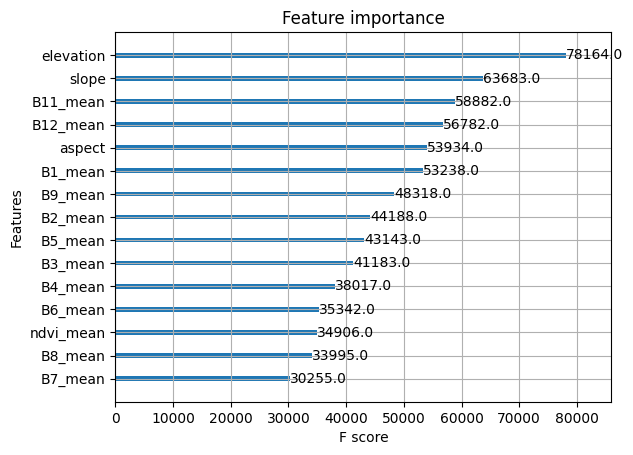

In [22]:
# variable importance plot
xgb.plot_importance(best_classifier)
plt.show()

Which predictors were most informative? Which spectral information was most informative? Can you imagine why these features would be most predictive of land cover class? Keep in mind this is for all land cover classes, not just crops/vegetation. 

## Assignment
In the code above, we used XGBoost for classifying land cover based on a set of input variables. Instead of classification, update this workflow to predict maize yields, a continuous outcome measure. Use the maize yield data provided in `training_data_for_yield.csv`. Report on your results in the same format as the pre-print paper:

> The predictions of maize yields were different from observed yields on average by about 1650 kg/ha, or 44% of the mean in observed yields (RMSE). The RMSE gives greater weight to outliers than the mean absolute error (MAE); when considering residual error irrespective of magnitude, average error in yield was 1300 kg/ha. The correlation between observed and predicted yield was moderate in the test set, with a value of 0.52 (and 0.65 in training).

That is, report on the RMSE, MAE, and correlation for both your train and test datasets. No need to focus a lot on hyperparameter tuning and optimization, save that for the bonus assignment. We recommend writing new code instead of modifying the code above so that you can have both a classification and yield pipeline.

## Bonus Assignment

The results reported in the pre-print paper are as follows: 
> Maize was classified with 83% accuracy, precision of 0.70, and recall of 0.44 and total maize cover was predicted within 4% of national statistics.
> The predictions of maize yields were different from observed yields on average by about 1650 kg/ha, or 44% of the mean in observed yields (RMSE).

Improve on either or both of the results for maize cover classification and yield prediction at the 10-meter pixel. You are encouraged to choose from any of the input variables available and/or to add in any additional open-source datasets that you think would be relevant to the prediction task. You can also continue to fine-tune the hyperparameters, use a different loss function (maybe one that optimizes performance for the maize class?) You can even try a different model entirely. Good luck!